# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
import pickle
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [3]:
data_prefix = "/home/carnd/data"
training_file = "{}/train.p".format(data_prefix)
testing_file = "{}/test.p".format(data_prefix)

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

In [5]:
### Replace each question mark with the appropriate value.

n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

2


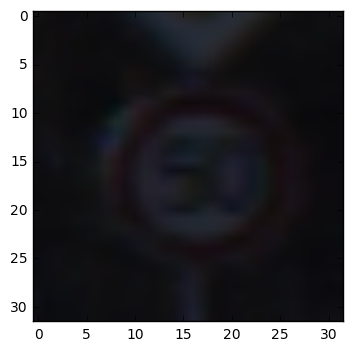

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
index = random.randint(0, n_train)
image = X_train[index]
plt.imshow(image)
print(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
def image_normalizer(image):
    lab= cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
    cl = clahe.apply(l)

    limg = cv2.merge((cl,a,b))
    img_bgr = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    img_bf = cv2.bilateralFilter(img_rgb, 9,20,20)
    return img_bf

In [8]:
def image_warp(img, pts_from):
    pts_to = np.float32([[0,0],[32,0],[0,32],[32,32]])
    M = cv2.getPerspectiveTransform(pts_from,pts_to)
    dst = cv2.warpPerspective(img,M,(32,32))
    return dst

In [9]:
delta = 5
delta_r = 5
pts_1 = np.float32([
    [delta,delta],
    [image_shape[0]-delta,delta],
    [delta,image_shape[1]-delta],
    [image_shape[0]-delta,image_shape[1]-delta]
])
pts_2 = np.float32([
    [-delta,-delta],
    [image_shape[0]+delta,-delta],
    [-delta,image_shape[1]+delta],
    [image_shape[0]+delta,image_shape[1]+delta]
])
pts_3 = np.float32([
    [delta_r,0],
    [image_shape[0],delta_r],
    [0,image_shape[1]-delta_r],
    [image_shape[0]-delta_r,image_shape[1]]
])
pts_4 = np.float32([
    [0, delta_r],
    [image_shape[0] - delta_r, 0],
    [delta_r, image_shape[1]],
    [image_shape[0],image_shape[1]-delta_r]
])

In [10]:
def image_normalizer_grey(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
        
    img_grey = np.zeros(image_shape, dtype=int)
    img_grey[:,:,0] = img
    img_grey[:,:,1] = img
    img_grey[:,:,2] = img
    return img_grey

34821


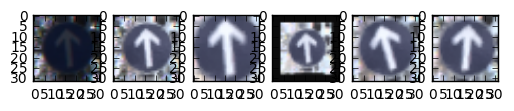

In [11]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def random_plot(X):
    index = random.randint(0, len(X))
    print(index)
    image = X[index]
    img = image_normalizer(image)
    

    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
    ax1.imshow(image)
    ax2.imshow(img)

    ax3.imshow(image_normalizer(image_warp(img=image, pts_from=pts_1)))
    ax4.imshow(image_normalizer(image_warp(img=image, pts_from=pts_2)))
    ax5.imshow(image_normalizer(image_warp(img=image, pts_from=pts_3)))
    ax6.imshow(image_normalizer(image_warp(img=image, pts_from=pts_4)))


random_plot(X_train)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [11]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.


In [12]:
def __set_augmenter(X, y):
    """generates additional distorted data
    via image_warp helper function
    pts_i - specifies the transform 
    """
    N = 5
    x_shape = X.shape
    y_shape = y.shape
    x_shape = (N*x_shape[0], x_shape[1], x_shape[2], x_shape[3])
    y_shape = (N*y_shape[0])
    XA = np.zeros(x_shape)
    YA = np.zeros(y_shape)
    
    for i in range(0, X.shape[0]):
        img1 = image_warp(img=X[i], pts_from=pts_1)
        img2 = image_warp(img=X[i], pts_from=pts_2)
        img3 = image_warp(img=X[i], pts_from=pts_3)
        img4 = image_warp(img=X[i], pts_from=pts_4)
        
        XA[N*i] = image_normalizer(X[i])
        XA[N*i + 1] = image_normalizer(img1)
        XA[N*i + 2] = image_normalizer(img2)
        XA[N*i + 3] = image_normalizer(img3)
        XA[N*i + 4] = image_normalizer(img4)
        
        YA[N*i] = y[i]
        YA[N*i + 1] = y[i]
        YA[N*i + 2] = y[i]
        YA[N*i + 3] = y[i]
        YA[N*i + 4] = y[i]
    return XA, YA

def __set_normalizer(X):
    XN = np.zeros(X.shape, dtype=object)
    for i in range(0, X.shape[0]):
        XN[i] = image_normalizer(X[i])
    return XN

X_train, y_train = __set_augmenter(X_train, y_train)
X_test = __set_normalizer(X_test)

In [13]:
X_train, y_train = shuffle(X_train, y_train)

XX_train, XX_validation, yy_train, yy_validation = train_test_split(
    X_train, y_train, test_size=0.2)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Each image in training and test set was pre-procesed using adaptive histogram equalization. I tried both Histograms Equalization and adaptive histogram equalization. The latter one works much better, because it helps to adjust contrast in smaller areas of the image which might be as important as the rest of the image.
In addition, for each original training image, I added 4 more transformed images: scaled up and scaled down and rotated clock-wise and counter-clockwise . Each of these transformed images was processed with adaptive histogram equalization as well. 

I noticed that validation and test accuracy was foing up as i started to add transformed images to the training set. However I was limited in how many trasformations I can perform to the training set, because I would het memory problem during learning. Thus i was able to add only those 4 transforms to the training data set.

In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 60
BATCH_SIZE = 128

In [15]:
def LeNet(x, dropout):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_shape[2], 10), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, dropout)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 10, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, dropout)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    fc0   = flatten(conv2)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    fc1    = tf.nn.relu(fc1)
    
    fc1    = tf.nn.dropout(fc1, dropout)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    fc2    = tf.nn.relu(fc2)
    
    fc2    = tf.nn.dropout(fc2, dropout)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [16]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [17]:
rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(XX_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        XX_train, yy_train = shuffle(XX_train, yy_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = XX_train[offset:end], yy_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
            
        validation_accuracy = evaluate(XX_validation, yy_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

# testing model on test data set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.180

EPOCH 2 ...
Validation Accuracy = 0.661

EPOCH 3 ...
Validation Accuracy = 0.743

EPOCH 4 ...
Validation Accuracy = 0.806

EPOCH 5 ...
Validation Accuracy = 0.857

EPOCH 6 ...
Validation Accuracy = 0.880

EPOCH 7 ...
Validation Accuracy = 0.910

EPOCH 8 ...
Validation Accuracy = 0.928

EPOCH 9 ...
Validation Accuracy = 0.935

EPOCH 10 ...
Validation Accuracy = 0.946

EPOCH 11 ...
Validation Accuracy = 0.952

EPOCH 12 ...
Validation Accuracy = 0.957

EPOCH 13 ...
Validation Accuracy = 0.958

EPOCH 14 ...
Validation Accuracy = 0.958

EPOCH 15 ...
Validation Accuracy = 0.965

EPOCH 16 ...
Validation Accuracy = 0.965

EPOCH 17 ...
Validation Accuracy = 0.966

EPOCH 18 ...
Validation Accuracy = 0.970

EPOCH 19 ...
Validation Accuracy = 0.970

EPOCH 20 ...
Validation Accuracy = 0.962

EPOCH 21 ...
Validation Accuracy = 0.967

EPOCH 22 ...
Validation Accuracy = 0.958

EPOCH 23 ...
Validation Accuracy = 0.973

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I had to use GPUs otherwise it was taking forever to complete

number (epochs) = 60
batch size = 128
optimizer = AdamOptimizer
learning rate = 0.001
dropout keep_probability = 0.8


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

1. i made sure I can execute basic LeNet code with the input images for this project and measured validation and test accuracy 
2. i started with the hypothesis that its only the shape of the traffic sign which matters and converted all images to greyscale. then i applied two transformations: Histograms Equalization and adaptive histogram equalization. adaptive histogram equalization was a winner. I understood the importance of local vs global image normalization.
3. i tried to investigate whether keeping color is more beneficial than having greyscale image. accuracy showed that color is definitely helpful.
4. I read Yann LeCun paper on traffic classification and a couple tutorials where people were metioning adding extra train samples by transforming original images. Once I did that accuracy went up,and i decided to stick with this idea.
5. I had to use AWS GPU server to proceed from now on - otherwise it was very slow to do it on my laptop
6. I realized i can add only 4 distorted images for one original image, otheriwse i would heve memory problems. Thus i was trying to experiment which distortions help most with accuracy.
7. Then i tried different settings with # of epochs and learning rate, and decided on selected values. i did not try that many different values.
8. Finally i questioned the parameters of LeNet whether it is sufficientry complex to be able to classify signs. However this was a risky path which may lead to overfitting. Thus i combined 2 steps in one : increased the depth of the first convolution layer and added drop_out regularisation, which further boost accuracy. 
9. achieved 0.96 accuracy on test data set

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [28]:
##Load the images and plot them here.
##Feel free to use as many code cells as needed.

I m using test images from 
https://github.com/KonArtist02/CarND-Traffic-Sign-Classifier-Project.git
I really appreciate someone in Germany taking photos for this project and uploading them to the class 

In [27]:
new_signs = "{}/new_signs.p".format(data_prefix)
with open(new_signs, mode='rb') as f:
    new_test = pickle.load(f)
X_new, y_new = new_test['data'], new_test['labels']

22


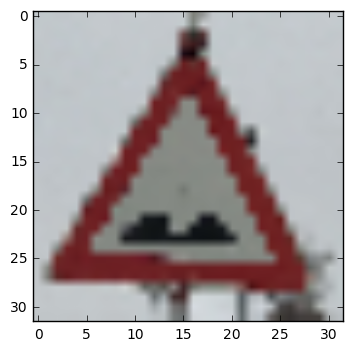

In [32]:
index = random.randint(0, len(X_new))
image = X_new[index]
plt.imshow(image)
print(y_new[index])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

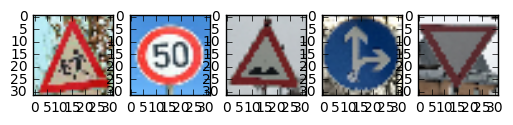

In [36]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.imshow(X_new[0])
ax2.imshow(X_new[1])
ax3.imshow(X_new[2])
ax4.imshow(X_new[4])
ax5.imshow(X_new[5])

After visualizing these new images, we can see that these signs are shot in good light with very good focus. the only possible problem i can think of is the background of the image

In [39]:
# pre-processing new images in the same way as we did for training and testing
XN_new = __set_normalizer(X_new)
"there are {} images in new test dataset".format(len(X_new))

'there are 29 images in new test dataset'

In [38]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(XN_new, y_new)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.966


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [46]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import csv
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()
print(signs)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


The trained model performed even better on these new test images (0.966 vs 0.96 on provided test samples)

In [65]:
softmax = tf.nn.softmax(logits)
top_3_p = tf.nn.top_k(softmax,3)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_3 = sess.run(top_3_p, feed_dict={x: X_new, y: y_new, keep_prob:1})


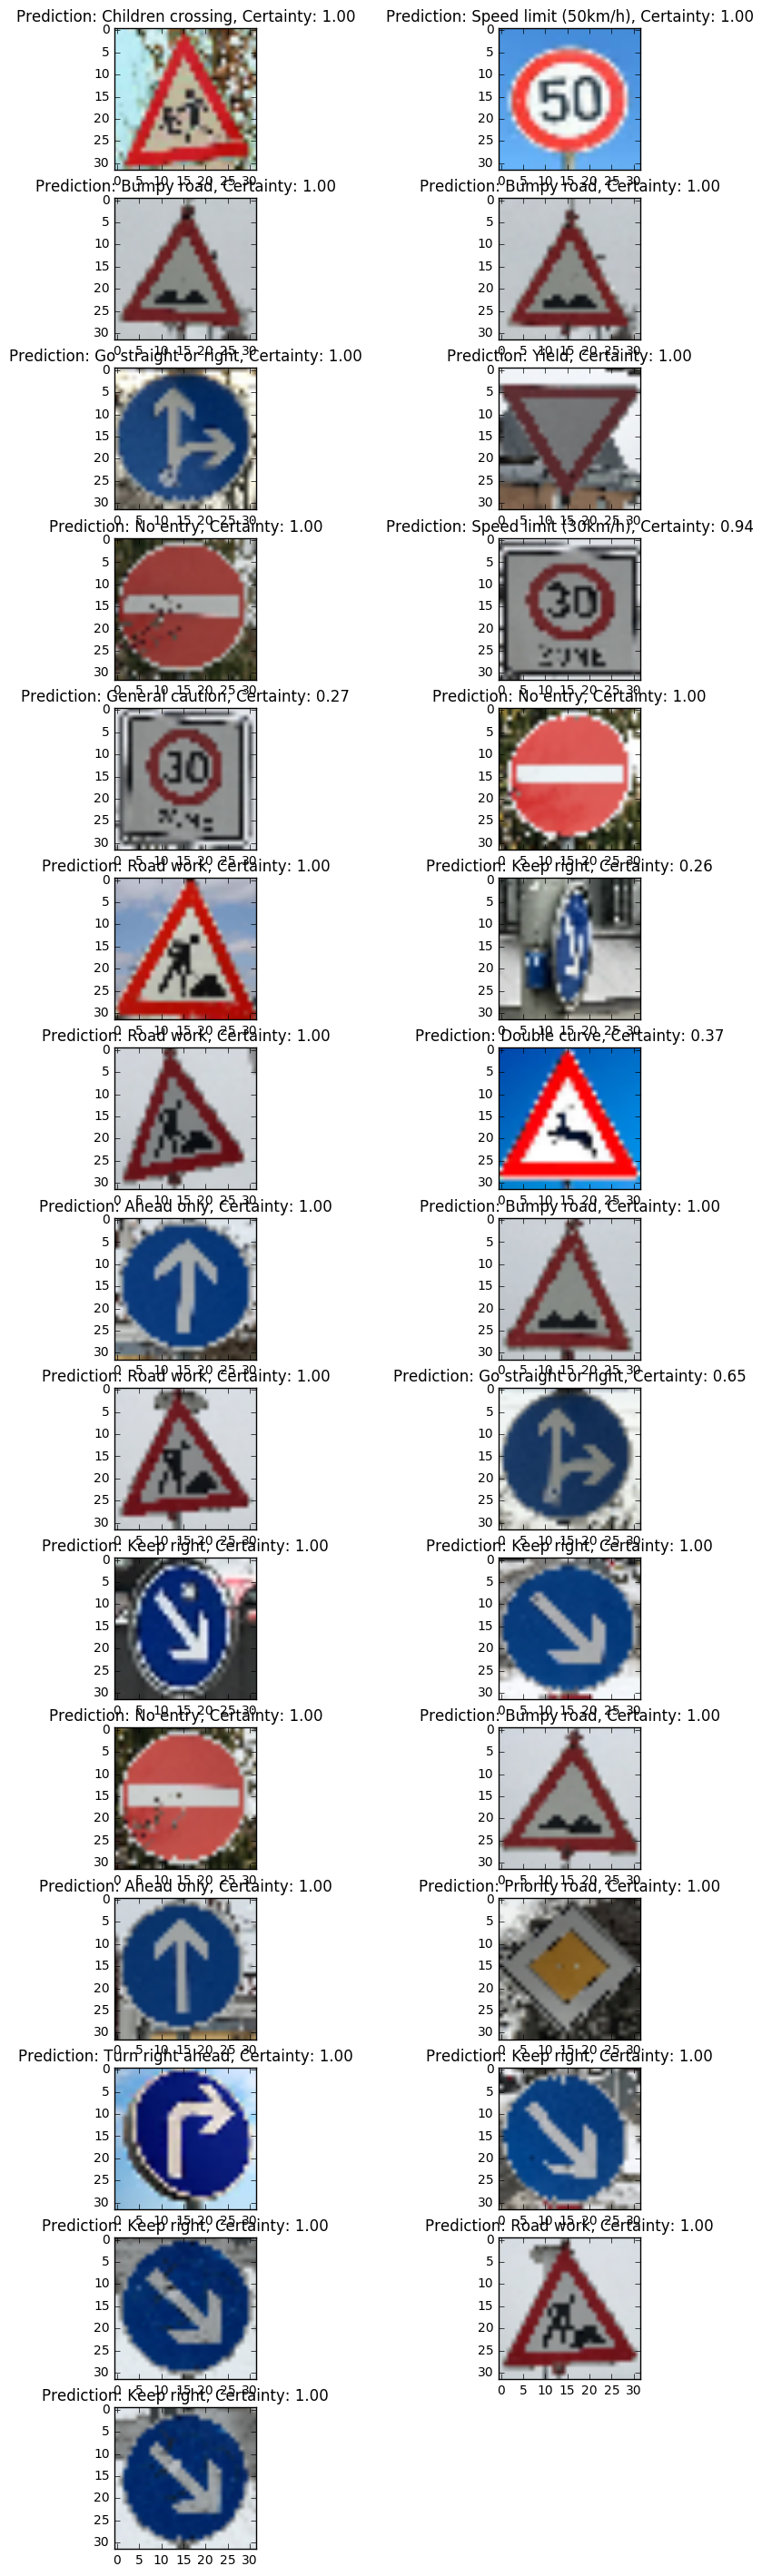

In [68]:
plt.figure(figsize=(10, 60))
for i in range(len(X_new)):
    plt.subplot(25,2,i+1)
    plt.imshow(X_new[i])
    plt.title("Prediction: {}, Certainty: {:.2f}".format(signs[top_3[1][i][0]], top_3[0][i][0]))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.